最简提示探索：上下文工程基础
==========================

本笔记本通过探索最小、原子的提示及其对大语言模型（LLM）输出和行为的直接影响，介绍了上下文工程的核心原理。

涵盖的关键概念：
1. 构建原子提示，实现最大清晰度和可控性
2. 通过标记数和模型响应质量衡量有效性
3. 迭代修改提示，实现快速反馈循环
4. 观察上下文漂移和最小提示边界
5. 从原子提示扩展到协议化外壳的基础

用法：
    # 在 Jupyter 或 Colab 中：
    %run 01_min_prompt.py
    # 或者
    # 独立编辑并运行每个部分，实验提示效果

注意事项：
    - 本笔记本的每个部分都为动手实验而设计。
    - 修改提示，观察分词和输出保真度的变化。
    - 可作为构建高级上下文工程工作流的基础。

In [23]:
import os
import time
import json
from typing import Dict, List, Any, Tuple, Optional
import matplotlib.pyplot as plt
# 引用client
from client import chat_completion
import tiktoken

# 如果你使用其他服务商，请相应调整
# 用于演示的简单 LLM 类
class SimpleLLM:
    """最简 LLM 接口演示。"""
    
    def __init__(self, model_name: str = "dummy-model"):
        """初始化 LLM 接口。"""
        self.model_name = model_name
        self.total_tokens_used = 0
        self.total_requests = 0
        
    def count_tokens(self, text: str) -> int:
        """
        使用分词器统计文本中的 token 数量。
        推荐使用 tiktoken 或 transformers 分词器。
        """
        try:
            enc = tiktoken.get_encoding("cl100k_base")
            return len(enc.encode(text))
        except ImportError:
            # 如果未安装 tiktoken，则回退为简单分词
            return len(text.split())
    
    def generate(self, prompt: str) -> str:
        """
        Generate text based on prompt using the chat_completion client.
        Also tracks token usage and request count.
        """
        # Count tokens and update stats
        tokens = self.count_tokens(prompt)
        self.total_tokens_used += tokens
        self.total_requests += 1
        
        # Call the chat_completion client
        result = chat_completion(prompt)
        return result
    
    def get_stats(self) -> Dict[str, Any]:
        """返回使用统计信息。"""
        return {
            "total_tokens": self.total_tokens_used,
            "total_requests": self.total_requests,
            "avg_tokens_per_request": self.total_tokens_used / max(1, self.total_requests)
        }
    
llm = SimpleLLM()

In [24]:
# ----- 实验 1：原子提示 -----
print("\n----- 实验 1：原子提示 -----")
print("让我们从最基本的单元开始：一个指令。")

atomic_prompt = "写一首关于编程的简短诗。"
tokens = llm.count_tokens(atomic_prompt)

print(f"\n原子提示: '{atomic_prompt}'")
print(f"Token 数量: {tokens}")
print("\n生成回复中...")
response = llm.generate(atomic_prompt)
print(f"\n回复:\n{response}")



----- 实验 1：原子提示 -----
让我们从最基本的单元开始：一个指令。

原子提示: '写一首关于编程的简短诗。'
Token 数量: 15

生成回复中...

回复:
敲击指尖如跳舞，  
代码行间闪思路。  
逻辑编织梦与路，  
世界由零一编著。


In [25]:
# ----- 实验 2：添加约束 -----
print("\n----- 实验 2：添加约束 -----")
print("现在让我们给原子提示添加约束，观察差异。")

# 让我们创建三个版本，约束逐渐增加
prompts = [
    "写一首关于编程的简短诗。",  # 原始版本
    "写一首关于编程的简短诗，要求4行。",  # 添加长度约束
    "用简单词语写一首关于编程的俳句。"  # 格式和词汇约束
]

# 测量标记数并生成响应
results = []
for i, prompt in enumerate(prompts):
    tokens = llm.count_tokens(prompt)
    print(f"\n提示 {i+1}: '{prompt}'")
    print(f"标记数量: {tokens}")
    
    start_time = time.time()
    response = llm.generate(prompt)
    end_time = time.time()
    
    results.append({
        "prompt": prompt,
        "tokens": tokens,
        "response": response,
        "latency": end_time - start_time
    })
    
    print(f"延迟: {results[-1]['latency']:.4f} 秒")
    print(f"响应:\n{response}")



----- 实验 2：添加约束 -----
现在让我们给原子提示添加约束，观察差异。

提示 1: '写一首关于编程的简短诗。'
标记数量: 15
延迟: 1.6332 秒
响应:
代码如诗行，  
指尖舞飞扬。  
逻辑织梦网，  
程序见光芒。

提示 2: '写一首关于编程的简短诗，要求4行。'
标记数量: 20
延迟: 2.4552 秒
响应:
代码如诗行，逻辑自成章，  
键下心世界，逐梦在云航。  
调试理思绪，光标映微光，  
点滴皆创造，智慧竞芬芳。

提示 3: '用简单词语写一首关于编程的俳句。'
标记数量: 19
延迟: 1.8965 秒
响应:
代码如流水  
思路缓缓流淌  
灯下夜微明



----- 实验 3：衡量投资回报率曲线 -----
让我们探索提示复杂度与输出质量之间的关系。


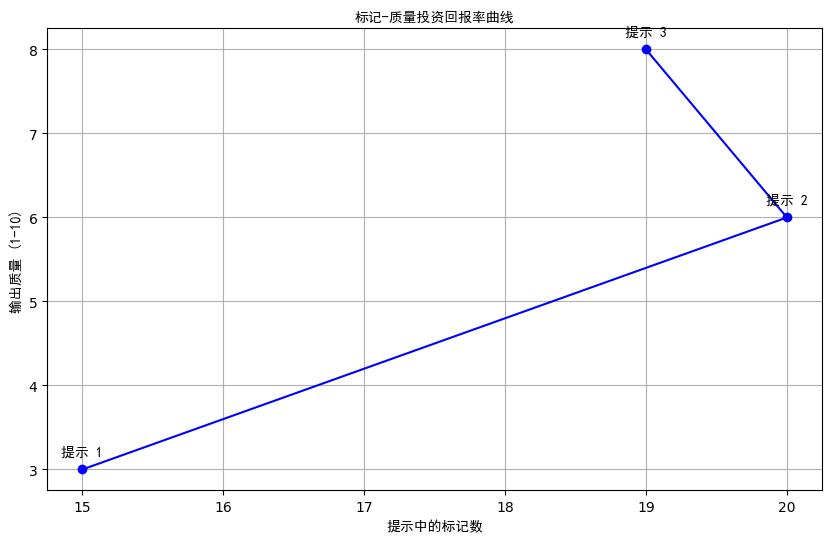

In [26]:
# ----- 实验 3：衡量投资回报率曲线 -----
print("\n----- 实验 3：衡量投资回报率曲线 -----")
print("让我们探索提示复杂度与输出质量之间的关系。")

# 在真实的笔记本中，您会为每个响应定义主观质量分数
# 对于本演示，我们将使用占位符值
quality_scores = [3, 6, 8]  # 1-10分制的占位符主观分数

# 绘制标记数与质量的关系图
plt.figure(figsize=(10, 6))
tokens_list = [r["tokens"] for r in results]
plt.plot(tokens_list, quality_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('提示中的标记数', fontproperties='SimHei')
plt.ylabel('输出质量 (1-10)', fontproperties='SimHei')
plt.title('标记-质量投资回报率曲线', fontproperties='SimHei')
plt.grid(True)

# 添加注释
for i, (x, y) in enumerate(zip(tokens_list, quality_scores)):
    plt.annotate(f"提示 {i+1}", (x, y), textcoords="offset points", 
                 xytext=(0, 10), ha='center', fontproperties='SimHei')

# 显示图表（在 Jupyter 中会内联显示）
plt.show()


In [27]:
# ----- 实验 4：最小上下文增强 -----
print("\n----- 实验 4：最小上下文增强 -----")
print("现在我们将添加最少的上下文来提高输出质量，同时保持较低的标记数。")

# 让我们创建一个带有少量策略性上下文的提示
enhanced_prompt = """任务：写一首关于编程的俳句。

俳句是一种三行诗，每行分别有5、7、5个音节。
专注于解决困难bug时的感受。"""

tokens = llm.count_tokens(enhanced_prompt)
print(f"\n增强提示:\n'{enhanced_prompt}'")
print(f"标记数量: {tokens}")

response = llm.generate(enhanced_prompt)
print(f"\n响应:\n{response}")



----- 实验 4：最小上下文增强 -----
现在我们将添加最少的上下文来提高输出质量，同时保持较低的标记数。

增强提示:
'任务：写一首关于编程的俳句。

俳句是一种三行诗，每行分别有5、7、5个音节。
专注于解决困难bug时的感受。'
标记数量: 58

响应:
深夜独坐，  
代码如迷雾散，  
一灯微明。


In [28]:
# ----- 实验 5：衡量一致性 -----
print("\n----- 实验 5：衡量一致性 -----")
print("让我们测试最小提示与增强提示的输出一致性。")

# 生成多个响应并衡量一致性的函数
def measure_consistency(prompt: str, n_samples: int = 3) -> Dict[str, Any]:
    """生成多个响应并衡量一致性指标。"""
    responses = []
    total_tokens = 0
    
    for _ in range(n_samples):
        response = llm.generate(prompt)
        responses.append(response)
        total_tokens += llm.count_tokens(prompt)
    
    # 在真实的笔记本中，您会实现适当的一致性指标
    # 例如响应之间的语义相似度
    consistency_score = 0.5  # 占位符值
    
    return {
        "prompt": prompt,
        "responses": responses,
        "total_tokens": total_tokens,
        "consistency_score": consistency_score
    }

# 比较基础提示与增强提示
basic_results = measure_consistency(prompts[0])
enhanced_results = measure_consistency(enhanced_prompt)

print(f"\n基础提示一致性分数: {basic_results['consistency_score']}")
print(f"增强提示一致性分数: {enhanced_results['consistency_score']}")



----- 实验 5：衡量一致性 -----
让我们测试最小提示与增强提示的输出一致性。

基础提示一致性分数: 0.5
增强提示一致性分数: 0.5


In [29]:
# ----- 结论 -----
print("\n----- 结论 -----")
print("实验的关键见解:")
print("1. 即使对提示做很小的改动也会显著影响输出质量")
print("2. token数量和质量之间存在一个投资回报率曲线,能找到最佳平衡点") 
print("3. 添加最小但具有策略性的上下文可以提高一致性")
print("4. 最好的提示应该清晰、简洁,并提供恰到好处的上下文")

print("\n本笔记本使用的总token数:", llm.get_stats()["total_tokens"])

# ----- 下一步 -----
print("\n----- 下一步 -----")
print("1. 用真实的LLM API尝试这些实验")
print("2. 实现合适的一致性和质量度量指标") 
print("3. 探索'分子'概念 - 组合多条指令")
print("4. 在上下文窗口中尝试少样本示例")

"""
读者练习:

1. 将这个笔记本连接到真实的LLM API(OpenAI、Anthropic等)
2. 用不同规模的模型测试相同的提示
3. 为你关心的任务创建自己的token-质量曲线
4. 为你的具体用例找到"最小可行上下文"

更多高级上下文工程技术请参见 02_expand_context.ipynb!
"""

# 如果这是Jupyter笔记本,我们会在这里将结果保存到文件
# with open('experiment_results.json', 'w') as f:
#     json.dump(results, f, indent=2)



----- 结论 -----
实验的关键见解:
1. 即使对提示做很小的改动也会显著影响输出质量
2. token数量和质量之间存在一个投资回报率曲线,能找到最佳平衡点
3. 添加最小但具有策略性的上下文可以提高一致性
4. 最好的提示应该清晰、简洁,并提供恰到好处的上下文

本笔记本使用的总token数: 346

----- 下一步 -----
1. 用真实的LLM API尝试这些实验
2. 实现合适的一致性和质量度量指标
3. 探索'分子'概念 - 组合多条指令
4. 在上下文窗口中尝试少样本示例


'\n读者练习:\n\n1. 将这个笔记本连接到真实的LLM API(OpenAI、Anthropic等)\n2. 用不同规模的模型测试相同的提示\n3. 为你关心的任务创建自己的token-质量曲线\n4. 为你的具体用例找到"最小可行上下文"\n\n更多高级上下文工程技术请参见 02_expand_context.ipynb!\n'